## pix2pix pytorch lightning

### Data loader

In [1]:
%matplotlib inline
import os
import sys
from PIL import Image
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import os
import torchvision
from argparse import ArgumentParser, Namespace
from collections import OrderedDict

In [3]:
from models.pix2pix.datasets import ImageDataset, FloorplanDataset

import albumentations as A
import torchvision.transforms as transforms

In [4]:
dataset_name = "floor/newyork"
img_height = 256
img_width = 256

In [5]:
transforms_ = [
            A.RandomResizedCrop(
                img_height,
                img_width,
            ),
#             A.Rotate(23),
#             A.HorizontalFlip(),
#             A.RandomBrightnessContrast(),
#             A.HueSaturationValue(),
#             A.RGBShift(),
#             A.RandomGamma(),
        ]

In [6]:
dataset = FloorplanDataset("./datasets/%s" % dataset_name, transforms_=transforms_, mode="test")

In [7]:
len(dataset)

53

In [8]:
def draw(A, B):    
    fig = plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(A)
    plt.title('original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(B)
    plt.title('mask')
    plt.axis('off')
    plt.show()

In [9]:
dataset.files[12]

'./datasets/floor/newyork/test/45719584.jpg'

In [19]:
for i in range(len(dataset)):
    item = dataset[i]
    print(item['A'].shape, item['B'].shape)
    break

(3, 256, 256) (3, 256, 256)


In [20]:
item['A'].shape, item['B'].shape

((3, 256, 256), (3, 256, 256))

### Train

In [13]:
from pytorch_lightning.trainer import Trainer
from models.pix2pix_model import Pix2PixModel
from torchsummary import summary
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path
from time import time

#### Model Summary

In [14]:
model = Pix2PixModel(dataset_name="floor/newyork")

In [15]:
train_loader = model.train_dataloader()

In [16]:
for batch in train_loader:
    print(batch['A'].shape)
    print(batch['B'].shape)
    break

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = model.to(device)
summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,408
       BatchNorm2d-3         [-1, 64, 256, 256]             128
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,728
       BatchNorm2d-6        [-1, 128, 128, 128]             256
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         294,912
       BatchNorm2d-9          [-1, 256, 64, 64]             512
             ReLU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         589,824
      BatchNorm2d-13          [-1, 256, 64, 64]             512
             ReLU-14          [-1, 256,

#### Model Training

In [18]:
tb_logger = TensorBoardLogger(
        f'logs',
        name=f'pix2pix_floorplan',
#         version=str(int(time())),
    )
log_dir = Path(tb_logger.log_dir)
log_dir.mkdir(parents=True, exist_ok=True)

In [19]:
model = Pix2PixModel(batch_size=2, dataset_name="floor/newyork")

In [20]:
trainer = Trainer(logger=tb_logger, weights_save_path=f'experiments', gpus=[0], max_epochs=100)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type            | Params
--------------------------------------------------------
0 | discriminator       | Discriminator   | 2 M   
1 | generator           | ResnetGenerator | 11 M  
2 | criterion_GAN       | MSELoss         | 0     
3 | criterion_pixelwise | L1Loss          | 0     
/home/nghia/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/home/nghia/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this m

/home/nghia/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


1

## Evaluate

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = model.to(device)

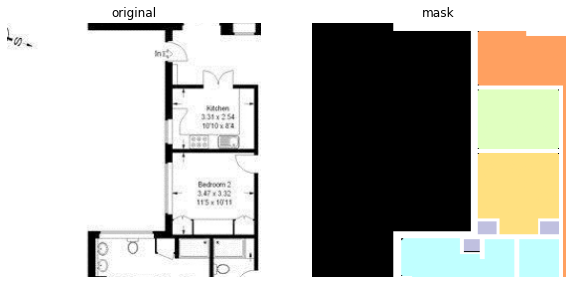

In [44]:
item = dataset[12]
draw(item['A'].transpose((1, 2, 0)), item['B'].transpose((1, 2, 0)))

In [45]:
input = torch.from_numpy(item['B']).unsqueeze(0)
input = input.to(device)
gt = torch.from_numpy(item['A']).unsqueeze(0)
gt = gt.to(device)

In [46]:
input.shape

torch.Size([1, 3, 256, 256])

In [47]:
generated = model(input)

In [48]:
generated.shape

torch.Size([1, 3, 256, 256])

In [49]:
img_sample = torch.cat((input, generated, gt), -1)
print(img_sample.shape)
grid = torchvision.utils.make_grid(img_sample)

torch.Size([1, 3, 256, 768])


In [83]:
def display_generated(grid):
    npgrid = grid.cpu().numpy()
    fig = plt.figure(figsize=(20, 10))

    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


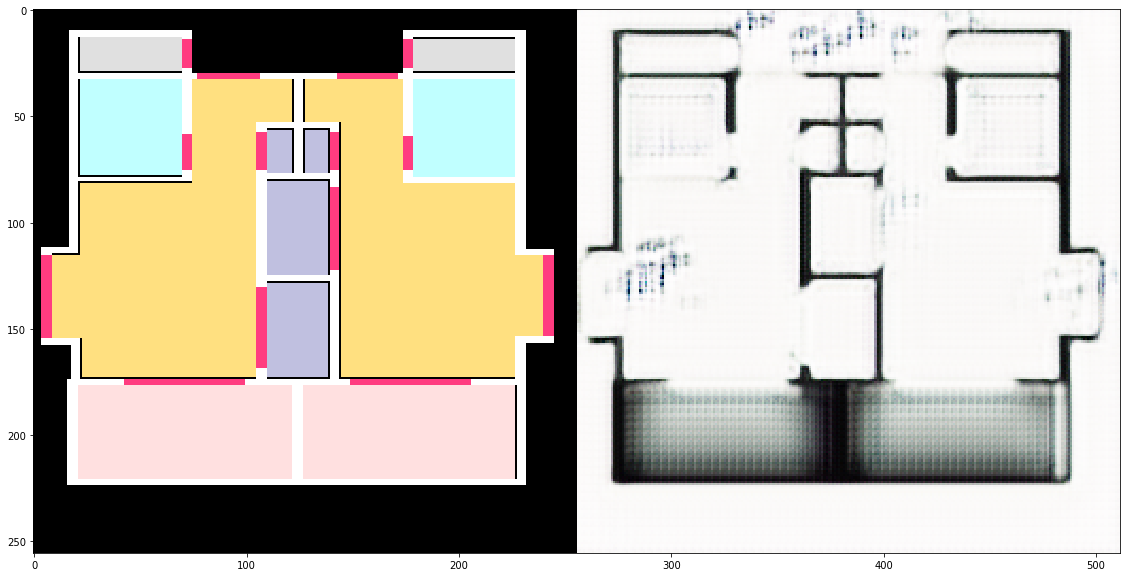

In [84]:
display_generated(grid)

#### JP Dataset

In [86]:
import glob
import re

In [87]:
dataset_name = "./datasets/floor/jp"
mode = "train"
img_height = 256
img_width = 256

In [90]:
files = sorted(glob.glob(os.path.join(dataset_name, mode) + "/*_multi.*"))

In [91]:
files[:10]

['./datasets/floor/jp/train/100_multi.png',
 './datasets/floor/jp/train/101_multi.png',
 './datasets/floor/jp/train/102_multi.png',
 './datasets/floor/jp/train/103_multi.png',
 './datasets/floor/jp/train/104_multi.png',
 './datasets/floor/jp/train/105_multi.png',
 './datasets/floor/jp/train/106_multi.png',
 './datasets/floor/jp/train/107_multi.png',
 './datasets/floor/jp/train/108_multi.png',
 './datasets/floor/jp/train/109_multi.png']

In [98]:
path_A = files[1]

In [99]:
im = Image.open(path_A).convert('RGB')
im_resized = im.resize((img_width, img_height))
img_A = np.array(im_resized).astype(np.float32).transpose((2, 0, 1))
img_A = img_A / 255.

In [100]:
input = torch.from_numpy(img_A).unsqueeze(0)
input = input.to(device)
input.shape

torch.Size([1, 3, 256, 256])

In [101]:
generated = model(input)
generated.shape

torch.Size([1, 3, 256, 256])

In [102]:
img_sample = torch.cat((input, generated), -1)
print(img_sample.shape)
grid = torchvision.utils.make_grid(img_sample)

torch.Size([1, 3, 256, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


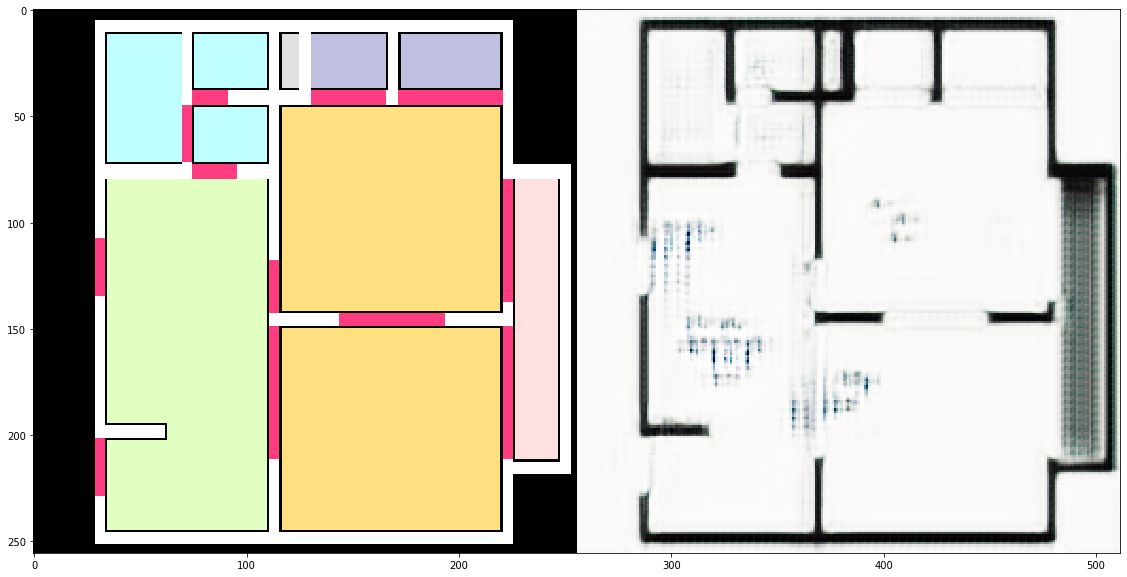

In [103]:
display_generated(grid)